In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

sns.set(style='whitegrid', palette='Set2')

## Loading and tokenizing sentences

In [2]:
# load Prasada & Dillingham (2006) sentences
df_2006 = pd.read_csv('data/prasada_2006_sentences.csv')
df_2006.columns = df_2006.columns.str.replace('.', '_')
display(df_2006.head())

# load Prasada et al. (2013) sentences
df_2013 = pd.read_csv('data/prasada_2013_sentences.csv')
df_2013.columns = df_2013.columns.str.replace('.', '_')
display(df_2013.head())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


,connection_type,connection_subtype,item,in_general,by_virtue_of,causal_essence,statistical,formal,should,prevalence_estimates,word1_singular,word2_singular,word1_plural,word2_plural,singular_googleNews,singular_wiki,plural_googleNews,plural_wiki
0,counterexample,counterexample,airplanes have sirens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,counterexample,counterexample,ambulances have wings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,counterexample,counterexample,cars are absorbent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,counterexample,counterexample,diapers have four wheels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,counterexample,counterexample,fire trucks are sharp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


,Predication_type,Type,Item,Kind,Truth_judgment,Cue_validity_estimate,Prevalence_estimate,Word1,Word2,to_include,plural_GoogleNews-vectors-negative300_bin,plural_FastText_cc_en_300_vec,singular_GoogleNews-vectors-negative300_bin,singular_FastText_cc_en_300_vec
0,Majority characteristic,Principled,Airplanes have wings,Artifact,2.91,0.11,95.32,airplanes,wings,1,0.254327,0.367735,0.313459,0.383928
1,Majority characteristic,Principled,Ambulances have sirens,Artifact,2.50,1.47,89.11,ambulances,sirens,1,0.456853,0.515955,0.294424,0.342587
2,Majority characteristic,Principled,Needles are sharp,Artifact,2.42,0.42,88.74,needles,sharp,1,0.158391,0.258372,0.218542,0.320193
3,Majority characteristic,Principled,Tables are flat,Artifact,2.29,0.05,87.95,tables,flat,1,0.183369,0.161889,0.190805,0.241408
4,Majority characteristic,Principled,Diapers are absorbent,Artifact,2.65,0.42,87.58,diapers,absorbent,1,0.396471,0.454671,0.409588,0.472291


In [3]:
# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Tokenizing Prasada & Dillingham (2006)

In [4]:
def tokenize(sentences, tokenizer):
    # add markers
    sentences = [f'[CLS] {sentence} [SEP]' for sentence in sentences]

    # tokenize
    tokenized = [tokenizer.tokenize(sentence) for sentence in sentences]
    
    # convert to indices
    indices = [tokenizer.convert_tokens_to_ids(sentence) for sentence in tokenized]

    def pad_indices(indices):
        # get length of longest sentence
        max_len = 0
        for sentence in indices:
            if len(sentence) > max_len:
                max_len = len(sentence)

        # return list of padded sentences
        return [sentence + [0] * (max_len - len(sentence)) for sentence in indices]

    padded = pad_indices(indices)

    # add class (all 1s)
    classes = [[1] * len(sentence) for sentence in padded]
    
    # cast tokens and classes to torch tensors
    token_tensor = torch.tensor(padded)
    class_tensor = torch.tensor(classes)
    
    return tokenized, token_tensor, class_tensor

In [5]:
# tokenize Prasada & Dillingham (2006) sentences
tokenized_2006, token_tensor_2006, class_tensor_2006 = tokenize(list(df_2006['item']), tokenizer)

# write to dataframe so we can manually annotate start and end indices of each concept
annotate_tokens = [str(sentence) for sentence in tokenized_2006]
df = pd.DataFrame(annotate_tokens, columns=['sentence'])
display(df.head())
df.to_csv('data/prasada_2006_tokenized.tsv', index=False, sep='\t')

,sentence
0,"['[CLS]', 'airplanes', 'have', 'sirens', '[SEP]']"
1,"['[CLS]', 'ambulance', '##s', 'have', 'wings',..."
2,"['[CLS]', 'cars', 'are', 'absorb', '##ent', '[..."
3,"['[CLS]', 'dia', '##pers', 'have', 'four', 'wh..."
4,"['[CLS]', 'fire', 'trucks', 'are', 'sharp', '[..."


In [6]:
# tokenize Prasada et al. (2013) sentences
tokenized_2013, token_tensor_2013, class_tensor_2013 = tokenize(list(df_2013['Item']), tokenizer)

# write to dataframe so we can manually annotate start and end indices of each concept
annotate_tokens = [str(sentence) for sentence in tokenized_2013]
df = pd.DataFrame(annotate_tokens, columns=['sentence'])
display(df.head())
df.to_csv('data/prasada_2013_tokenized.tsv', index=False, sep='\t')

,sentence
0,"['[CLS]', 'airplanes', 'have', 'wings', '[SEP]']"
1,"['[CLS]', 'ambulance', '##s', 'have', 'sirens'..."
2,"['[CLS]', 'needles', 'are', 'sharp', '[SEP]']"
3,"['[CLS]', 'tables', 'are', 'flat', '[SEP]']"
4,"['[CLS]', 'dia', '##pers', 'are', 'absorb', '#..."


## Extracting word embeddings from BERT

In [7]:
# load pretrained BERT in eval mode
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval();

### Prasada & Dillingham (2006)

In [8]:
# run forward pass of BERT of our token tensors, no_grad means BERT does not construct a full graph
with torch.no_grad():
    outputs = model(token_tensor_2006, class_tensor_2006)
    hidden_states = outputs[2]  # grab hidden layer activations

In [9]:
# stack hidden layer states into a single tensor
token_embeddings_2006 = torch.stack(hidden_states, dim=0)

# swap dimensions to order sentence, token, layer, node
token_embeddings_2006 = token_embeddings_2006.permute(1,2,0,3)

### Prasada et al. (2013)

In [10]:
# run forward pass of BERT of our token tensors, no_grad means BERT does not construct a full graph
with torch.no_grad():
    outputs = model(token_tensor_2013, class_tensor_2013)
    hidden_states = outputs[2]  # grab hidden layer activations

In [11]:
# stack hidden layer states into a single tensor
token_embeddings_2013 = torch.stack(hidden_states, dim=0)

# swap dimensions to order sentence, token, layer, node
token_embeddings_2013 = token_embeddings_2013.permute(1,2,0,3)

## Computing cosine similarities between concept embeddings and property embeddings

### Using first and last tokens to represent concepts and properties
To simplify the (complex) mapping from concepts and properties to tokens (and vice versa) we start by using the first and last tokens in the sequence. For some sentences this works okay (e.g. "airplanes have wings"), while for other sentences it is obviously too simplified (e.g. "diapers are absorbent", in which "diapers" and "absorbent" are decomposed into two tokens each).

Still, we can use it as a rough baseline to which we can compare later refinements of this method.

In [12]:
norm = lambda x, ax=0: x / np.linalg.norm(x, axis=ax)
cos = lambda a, b: np.dot(norm(a), norm(b))

def cos_tensor(tensor, sentence_idx, word1_idx, word2_idx):
    word1 = torch.sum(tensor[sentence_idx, word1_idx, -4:], dim=0)
    word2 = torch.sum(tensor[sentence_idx, word2_idx, -4:], dim=0)
    return cos(word1, word2)

#### Prasada & Dillingham (2006)

In [13]:
sims = []
for i, sentence in enumerate(tokenized_2006):
    sims.append(cos_tensor(token_embeddings_2006, i, 1, len(sentence) - 2))
    print(f'{sims[-1]:.2f}: {sentence}')

0.59: ['[CLS]', 'airplanes', 'have', 'sirens', '[SEP]']
0.54: ['[CLS]', 'ambulance', '##s', 'have', 'wings', '[SEP]']
0.40: ['[CLS]', 'cars', 'are', 'absorb', '##ent', '[SEP]']
0.32: ['[CLS]', 'dia', '##pers', 'have', 'four', 'wheels', '[SEP]']
0.37: ['[CLS]', 'fire', 'trucks', 'are', 'sharp', '[SEP]']
0.49: ['[CLS]', 'needles', 'have', 'hose', '##s', '[SEP]']
0.40: ['[CLS]', 'rain', '##coat', '##s', 'have', 'wheels', '[SEP]']
0.35: ['[CLS]', 'roller', 'skate', '##s', 'are', 'water', '##proof', '[SEP]']
0.47: ['[CLS]', 'sand', '##paper', 'cuts', '[SEP]']
0.59: ['[CLS]', 'scissors', 'are', 'rough', '[SEP]']
0.72: ['[CLS]', 'airplanes', 'have', 'wings', '[SEP]']
0.63: ['[CLS]', 'ambulance', '##s', 'have', 'sirens', '[SEP]']
0.61: ['[CLS]', 'cars', 'have', 'four', 'wheels', '[SEP]']
0.31: ['[CLS]', 'dia', '##pers', 'are', 'absorb', '##ent', '[SEP]']
0.42: ['[CLS]', 'fire', 'trucks', 'have', 'hose', '##s', '[SEP]']
0.66: ['[CLS]', 'needles', 'are', 'sharp', '[SEP]']
0.39: ['[CLS]', 'rain',

In [14]:
df_2006['BERT_cosine'] = sims
display(df_2006.head())

,connection_type,connection_subtype,item,in_general,by_virtue_of,causal_essence,statistical,formal,should,prevalence_estimates,word1_singular,word2_singular,word1_plural,word2_plural,singular_googleNews,singular_wiki,plural_googleNews,plural_wiki,BERT_cosine
0,counterexample,counterexample,airplanes have sirens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587605
1,counterexample,counterexample,ambulances have wings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537026
2,counterexample,counterexample,cars are absorbent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404736
3,counterexample,counterexample,diapers have four wheels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317800
4,counterexample,counterexample,fire trucks are sharp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369291


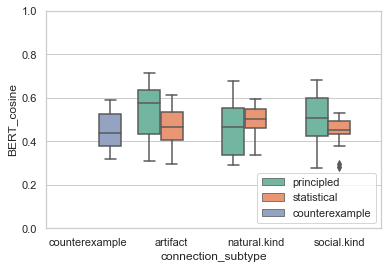

In [15]:
#ax = sns.violinplot(data=df_2006,
#               hue='connection_type', x='connection_subtype',
#               y='BERT_cosine', inner='quartile', cut=0)
ax = sns.boxplot(data=df_2006,
               hue='connection_type', x='connection_subtype',
               hue_order=['principled', 'statistical', 'counterexample'],
               y='BERT_cosine', dodge=True)
ax.set(ylim=[0, 1]);
ax.legend(loc=4);

#### Prasada & Dillingham (2006)

In [16]:
sims = []
for i, sentence in enumerate(tokenized_2013):
    sims.append(cos_tensor(token_embeddings_2013, i, 1, len(sentence) - 2))
    print(f'{sims[-1]:.2f}: {sentence}')

0.73: ['[CLS]', 'airplanes', 'have', 'wings', '[SEP]']
0.65: ['[CLS]', 'ambulance', '##s', 'have', 'sirens', '[SEP]']
0.68: ['[CLS]', 'needles', 'are', 'sharp', '[SEP]']
0.51: ['[CLS]', 'tables', 'are', 'flat', '[SEP]']
0.33: ['[CLS]', 'dia', '##pers', 'are', 'absorb', '##ent', '[SEP]']
0.69: ['[CLS]', 'birds', 'have', 'wings', '[SEP]']
0.51: ['[CLS]', 'lemon', '##s', 'are', 'sour', '[SEP]']
0.42: ['[CLS]', 'leopard', '##s', 'have', 'spots', '[SEP]']
0.52: ['[CLS]', 'dogs', 'have', 'tails', '[SEP]']
0.57: ['[CLS]', 'feathers', 'are', 'light', '[SEP]']
0.65: ['[CLS]', 'scissors', 'cut', '[SEP]']
0.54: ['[CLS]', 'horses', 'have', 'four', 'legs', '[SEP]']
0.55: ['[CLS]', 'sheep', 'produce', 'milk', '[SEP]']
0.60: ['[CLS]', 'lions', 'have', 'mane', '##s', '[SEP]']
0.51: ['[CLS]', 'deer', 'have', 'ant', '##lers', '[SEP]']
0.54: ['[CLS]', 'ducks', 'lay', 'eggs', '[SEP]']
0.53: ['[CLS]', 'elk', 'have', 'ant', '##lers', '[SEP]']
0.62: ['[CLS]', 'cows', 'have', 'ud', '##ders', '[SEP]']
0.50: ['

In [17]:
df_2013['BERT_cosine'] = sims
display(df_2013.head())

,Predication_type,Type,Item,Kind,Truth_judgment,Cue_validity_estimate,Prevalence_estimate,Word1,Word2,to_include,plural_GoogleNews-vectors-negative300_bin,plural_FastText_cc_en_300_vec,singular_GoogleNews-vectors-negative300_bin,singular_FastText_cc_en_300_vec,BERT_cosine
0,Majority characteristic,Principled,Airplanes have wings,Artifact,2.91,0.11,95.32,airplanes,wings,1,0.254327,0.367735,0.313459,0.383928,0.726797
1,Majority characteristic,Principled,Ambulances have sirens,Artifact,2.50,1.47,89.11,ambulances,sirens,1,0.456853,0.515955,0.294424,0.342587,0.648791
2,Majority characteristic,Principled,Needles are sharp,Artifact,2.42,0.42,88.74,needles,sharp,1,0.158391,0.258372,0.218542,0.320193,0.679064
3,Majority characteristic,Principled,Tables are flat,Artifact,2.29,0.05,87.95,tables,flat,1,0.183369,0.161889,0.190805,0.241408,0.509944
4,Majority characteristic,Principled,Diapers are absorbent,Artifact,2.65,0.42,87.58,diapers,absorbent,1,0.396471,0.454671,0.409588,0.472291,0.334843


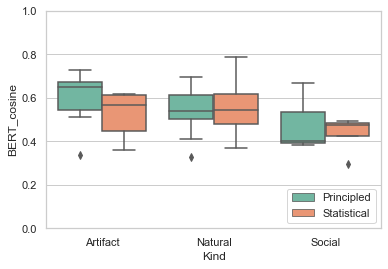

In [18]:
ax = sns.boxplot(data=df_2013,
               hue='Type', x='Kind',
               y='BERT_cosine', dodge=True)
ax.set(ylim=[0, 1]);
ax.legend(loc=4);

### Using multi-word phrases to represent concepts and properties
Instead of using the first and last tokens in the sequence to represent the word and its property (which is obviously oversimplified, e.g. "diapers are absorbent" is reduced to `dia`  and `##ent`) we'll use the sum of all token embeddings generated for a given concept or property.

For example, "diapers are absorbent" is now represented as:  
Concept: `sum(dia, ##pers)`  
Property: `sum(are, absorb, ##ent)`

#### Prasada et al. (2013)

In [19]:
df_idx_2006 = pd.read_csv('data/prasada_2006_annotated.tsv', sep='\t')
display(df_idx_2006.head())

,sentence,concept_start,concept_end,verb_start,property_start,property_end
0,"['[CLS]', 'airplanes', 'have', 'sirens', '[SEP]']",1,1,2,3,3
1,"['[CLS]', 'ambulance', '##s', 'have', 'wings',...",1,2,3,4,4
2,"['[CLS]', 'cars', 'are', 'absorb', '##ent', '[...",1,1,2,3,4
3,"['[CLS]', 'dia', '##pers', 'have', 'four', 'wh...",1,2,3,4,5
4,"['[CLS]', 'fire', 'trucks', 'are', 'sharp', '[...",1,2,3,4,4


In [20]:
def cos_tensor_multiword(tensor, df, idx):
    slice1 = slice(int(df.loc[idx, 'concept_start']), int(df.loc[idx, 'concept_end']) + 1, None)
    word1 = torch.sum(tensor[idx, slice1, -4:], dim=(0, 1))
    slice2 = slice(int(df.loc[idx, 'property_start']), int(df.loc[idx, 'property_end']) + 1, None)
    word2 = torch.sum(tensor[idx, slice2, -4:], dim=(0, 1))
    return cos(word1, word2)

In [21]:
sims = []
for i, sentence in enumerate(tokenized_2006):
    sims.append(cos_tensor_multiword(token_embeddings_2006, df_idx_2006, i))
    print(f'{sims[-1]:.2f}: {sentence}')

0.59: ['[CLS]', 'airplanes', 'have', 'sirens', '[SEP]']
0.64: ['[CLS]', 'ambulance', '##s', 'have', 'wings', '[SEP]']
0.38: ['[CLS]', 'cars', 'are', 'absorb', '##ent', '[SEP]']
0.48: ['[CLS]', 'dia', '##pers', 'have', 'four', 'wheels', '[SEP]']
0.49: ['[CLS]', 'fire', 'trucks', 'are', 'sharp', '[SEP]']
0.59: ['[CLS]', 'needles', 'have', 'hose', '##s', '[SEP]']
0.53: ['[CLS]', 'rain', '##coat', '##s', 'have', 'wheels', '[SEP]']
0.51: ['[CLS]', 'roller', 'skate', '##s', 'are', 'water', '##proof', '[SEP]']
0.51: ['[CLS]', 'sand', '##paper', 'cuts', '[SEP]']
0.59: ['[CLS]', 'scissors', 'are', 'rough', '[SEP]']
0.72: ['[CLS]', 'airplanes', 'have', 'wings', '[SEP]']
0.70: ['[CLS]', 'ambulance', '##s', 'have', 'sirens', '[SEP]']
0.63: ['[CLS]', 'cars', 'have', 'four', 'wheels', '[SEP]']
0.50: ['[CLS]', 'dia', '##pers', 'are', 'absorb', '##ent', '[SEP]']
0.65: ['[CLS]', 'fire', 'trucks', 'have', 'hose', '##s', '[SEP]']
0.66: ['[CLS]', 'needles', 'are', 'sharp', '[SEP]']
0.64: ['[CLS]', 'rain',

In [22]:
df_2006['BERT_cosine_multiword'] = sims
display(df_2006.head())

,connection_type,connection_subtype,item,in_general,by_virtue_of,causal_essence,statistical,formal,should,prevalence_estimates,word1_singular,word2_singular,word1_plural,word2_plural,singular_googleNews,singular_wiki,plural_googleNews,plural_wiki,BERT_cosine,BERT_cosine_multiword
0,counterexample,counterexample,airplanes have sirens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.587605,0.587605
1,counterexample,counterexample,ambulances have wings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537026,0.640633
2,counterexample,counterexample,cars are absorbent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404736,0.381397
3,counterexample,counterexample,diapers have four wheels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317800,0.480630
4,counterexample,counterexample,fire trucks are sharp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369291,0.488296


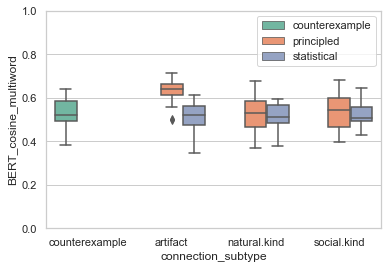

In [48]:
#ax = sns.violinplot(data=df_2006,
#               hue='connection_type', x='connection_subtype',
#               y='BERT_cosine_multiword', inner='quartile', cut=0)
ax = sns.boxplot(data=df_2006,
               hue='connection_type', x='connection_subtype',
               y='BERT_cosine_multiword', dodge=True)
ax.set(ylim=[0, 1]);
ax.legend(loc=1);
plt.savefig('figures/prasada_2006_by_kind.png', dpi=300)

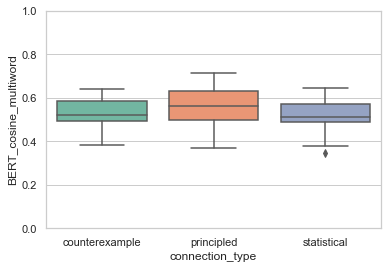

In [39]:
#ax = sns.violinplot(data=df_2006,
#                x='connection_type',
#               y='BERT_cosine_multiword', inner='quartile', cut=0)
ax = sns.boxplot(data=df_2006,
               x='connection_type',
               y='BERT_cosine_multiword', dodge=True)
ax.set(ylim=[0, 1]);
plt.savefig('figures/prasada_2006_by_type.png', dpi=300)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BERT_cosine_multiword_sigma, connection_type, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


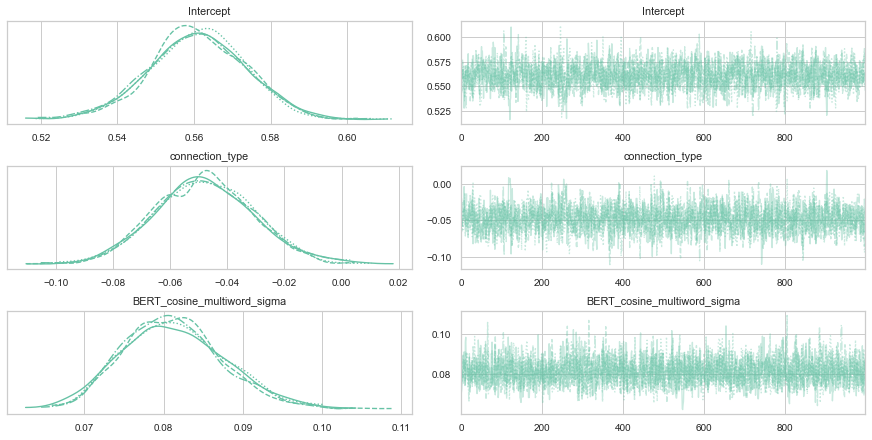

In [25]:
import bambi
import arviz as az

model = bambi.Model(df_2006[df_2006['connection_type'] != 'counterexample'])
result = model.fit('BERT_cosine_multiword ~ connection_type')
g = az.plot_trace(result)

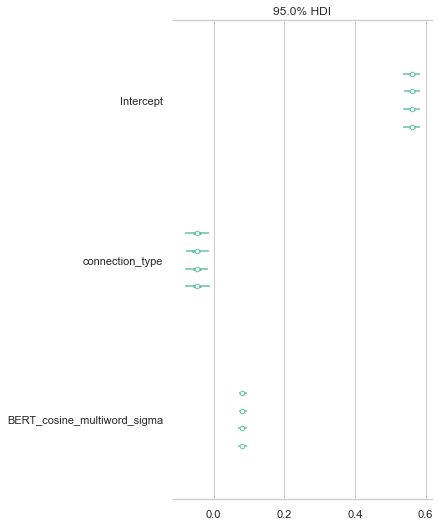

In [26]:
g = az.plot_forest(result, hdi_prob=.95)

#### Prasada et al. (2013)

In [27]:
df_idx_2013 = pd.read_csv('data/prasada_2013_annotated.tsv', sep='\t')
display(df_idx_2013.head())

,sentence,concept_start,concept_end,verb_start,property_start,property_end
0,"['[CLS]', 'airplanes', 'have', 'wings', '[SEP]']",1,1,2,3,3
1,"['[CLS]', 'ambulance', '##s', 'have', 'sirens'...",1,2,3,4,4
2,"['[CLS]', 'needles', 'are', 'sharp', '[SEP]']",1,1,2,3,3
3,"['[CLS]', 'tables', 'are', 'flat', '[SEP]']",1,1,2,3,3
4,"['[CLS]', 'dia', '##pers', 'are', 'absorb', '#...",1,2,3,4,5


In [28]:
sims = []
for i, sentence in enumerate(tokenized_2013):
    sims.append(cos_tensor_multiword(token_embeddings_2013, df_idx_2013, i))
    print(f'{sims[-1]:.2f}: {sentence}')

0.73: ['[CLS]', 'airplanes', 'have', 'wings', '[SEP]']
0.72: ['[CLS]', 'ambulance', '##s', 'have', 'sirens', '[SEP]']
0.68: ['[CLS]', 'needles', 'are', 'sharp', '[SEP]']
0.51: ['[CLS]', 'tables', 'are', 'flat', '[SEP]']
0.52: ['[CLS]', 'dia', '##pers', 'are', 'absorb', '##ent', '[SEP]']
0.69: ['[CLS]', 'birds', 'have', 'wings', '[SEP]']
0.58: ['[CLS]', 'lemon', '##s', 'are', 'sour', '[SEP]']
0.58: ['[CLS]', 'leopard', '##s', 'have', 'spots', '[SEP]']
0.52: ['[CLS]', 'dogs', 'have', 'tails', '[SEP]']
0.57: ['[CLS]', 'feathers', 'are', 'light', '[SEP]']
0.65: ['[CLS]', 'scissors', 'cut', '[SEP]']
0.51: ['[CLS]', 'horses', 'have', 'four', 'legs', '[SEP]']
0.55: ['[CLS]', 'sheep', 'produce', 'milk', '[SEP]']
0.68: ['[CLS]', 'lions', 'have', 'mane', '##s', '[SEP]']
0.55: ['[CLS]', 'deer', 'have', 'ant', '##lers', '[SEP]']
0.54: ['[CLS]', 'ducks', 'lay', 'eggs', '[SEP]']
0.58: ['[CLS]', 'elk', 'have', 'ant', '##lers', '[SEP]']
0.61: ['[CLS]', 'cows', 'have', 'ud', '##ders', '[SEP]']
0.54: ['

In [29]:
df_2013['BERT_cosine_multiword'] = sims
display(df_2013.head())

,Predication_type,Type,Item,Kind,Truth_judgment,Cue_validity_estimate,Prevalence_estimate,Word1,Word2,to_include,plural_GoogleNews-vectors-negative300_bin,plural_FastText_cc_en_300_vec,singular_GoogleNews-vectors-negative300_bin,singular_FastText_cc_en_300_vec,BERT_cosine,BERT_cosine_multiword
0,Majority characteristic,Principled,Airplanes have wings,Artifact,2.91,0.11,95.32,airplanes,wings,1,0.254327,0.367735,0.313459,0.383928,0.726797,0.726797
1,Majority characteristic,Principled,Ambulances have sirens,Artifact,2.50,1.47,89.11,ambulances,sirens,1,0.456853,0.515955,0.294424,0.342587,0.648791,0.719253
2,Majority characteristic,Principled,Needles are sharp,Artifact,2.42,0.42,88.74,needles,sharp,1,0.158391,0.258372,0.218542,0.320193,0.679064,0.679064
3,Majority characteristic,Principled,Tables are flat,Artifact,2.29,0.05,87.95,tables,flat,1,0.183369,0.161889,0.190805,0.241408,0.509944,0.509944
4,Majority characteristic,Principled,Diapers are absorbent,Artifact,2.65,0.42,87.58,diapers,absorbent,1,0.396471,0.454671,0.409588,0.472291,0.334843,0.519965


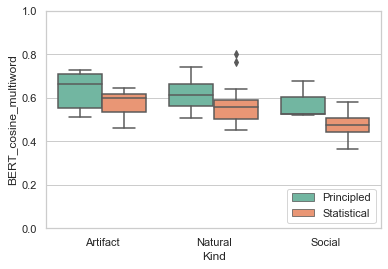

In [41]:
#ax = sns.violinplot(data=df_2006,
#               hue='connection_type', x='connection_subtype',
#               y='BERT_cosine_multiword', inner='quartile', cut=0)
ax = sns.boxplot(data=df_2013,
               hue='Type', x='Kind',
               y='BERT_cosine_multiword', dodge=True)
ax.set(ylim=[0, 1]);
ax.legend(loc=4);
plt.savefig('figures/prasada_2013_by_kind.png', dpi=300)

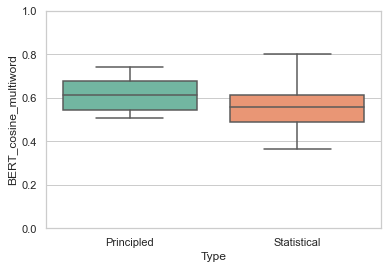

In [43]:
#ax = sns.violinplot(data=df_2006,
#                x='connection_type',
#               y='BERT_cosine_multiword', inner='quartile', cut=0)
ax = sns.boxplot(data=df_2013,
               x='Type',
               y='BERT_cosine_multiword', dodge=True)
ax.set(ylim=[0, 1]);
plt.savefig('figures/prasada_2013_by_type.png', dpi=300)

Automatically removing 24/84 rows from the dataset.
Modeling the probability that Type==Principled
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BERT_cosine_multiword, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8815388915226899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818436996674007, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6886637137684335, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


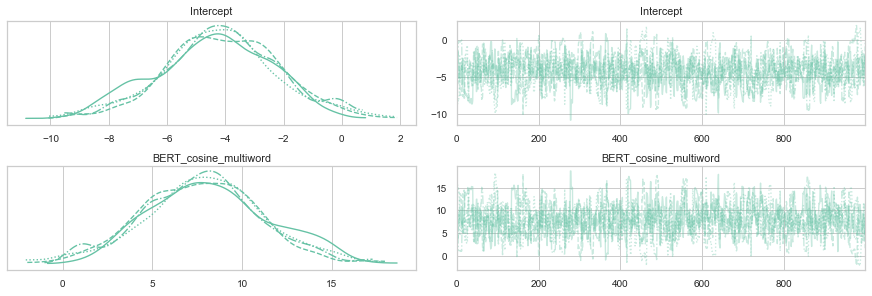

In [57]:
import bambi
import arviz as az

model = bambi.Model(df_2013, dropna=True)
result = model.fit('Type ~ BERT_cosine_multiword', family='bernoulli')
g = az.plot_trace(result)

Automatically removing 24/84 rows from the dataset.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BERT_cosine_multiword_sigma, Type, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8940973412637853, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794220707768468, but should be close to 0.8. Try to increase the number of tuning steps.


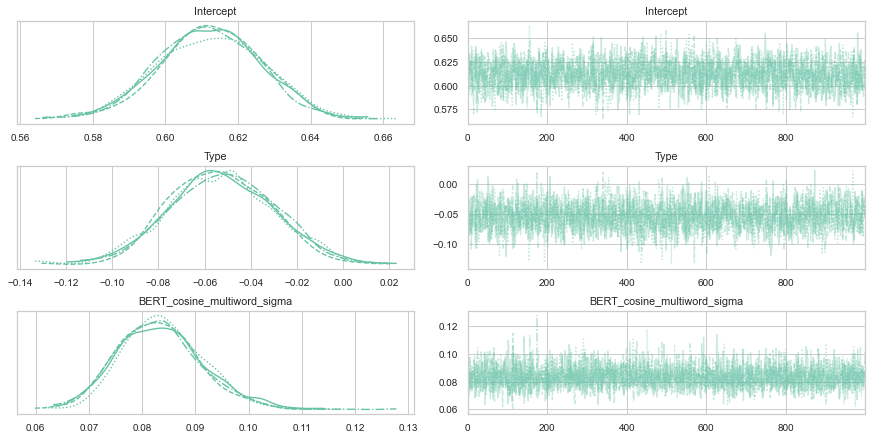

In [55]:
import bambi
import arviz as az

model = bambi.Model(df_2013, dropna=True)
result = model.fit('BERT_cosine_multiword ~ Type')
g = az.plot_trace(result)

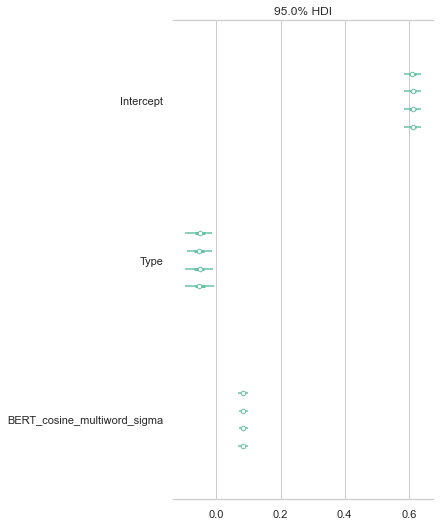

In [56]:
g = az.plot_forest(result, hdi_prob=.95)

## Computing sentence-level loss using BERT
This is work in progress.

In [34]:
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

with torch.no_grad():
    loss = model(token_tensor, labels=torch.tensor([]))[0]

print(np.exp(loss.detach().numpy()).shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'token_tensor' is not defined